# Spectral Graph Clustering (Ng–Jordan–Weiss) – Homework ID2222

In this notebook we implement and test the **K-eigenvector spectral clustering algorithm**
described in:

> Andrew Y. Ng, Michael I. Jordan, Yair Weiss,  
> *On Spectral Clustering: Analysis and an Algorithm*, NIPS 2001. :contentReference[oaicite:0]{index=0}  

We apply the algorithm to two graphs provided with the homework:

- `example1.dat` – real social network of physicians (Illinois towns).
- `example2.dat` – synthetic graph.

The notebook is structured as follows:

1. **Implementation details and helper functions**
2. **Warm-up: eigenvalues, Laplacian, and Fiedler vector**
3. **Ng–Jordan–Weiss K-eigenvector algorithm**
4. **Analysis of `example1.dat`**
5. **Analysis of `example2.dat`**
6. **Short discussion / report summary**

The implementation follows the spectral clustering lecture notes. :contentReference[oaicite:1]{index=1}


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.cluster import KMeans

import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.linalg as la


## 0. Data loading

The datasets `example1.dat` and `example2.dat` are provided on the course **Canvas**
page for this homework.  

In [ ]:
data_dir = Path("data")  

path_example1 = data_dir / "example1.dat"
path_example2 = data_dir / "example2.dat"

print("example1 path:", path_example1.resolve())
print("example2 path:", path_example2.resolve())


example1 path: /Users/utente1/Desktop/KTH/DATA MINING/Data-Mining-Project/homework4/data/example1.dat
example2 path: /Users/utente1/Desktop/KTH/DATA MINING/Data-Mining-Project/homework4/data/example2.dat


## 0+ Helper functions

We first implement utility functions to:

1. Load an **edge list** from a `.dat` file.
2. Build the **adjacency matrix**.
3. Compute **Laplacians** (unnormalized and normalized).
4. Compute eigenvalues/eigenvectors and the **Fiedler vector**.
5. Estimate the number of clusters using the **eigengap heuristic**.


In [ ]:
def load_edge_list(path, directed=False):
    """
    Load a comma-separated edge list from `path` and return
    a (dense) adjacency matrix A.

    Assumptions:
    - Each row has two integers: "u,v".
    - Node IDs are 1-based (as in the Matlab example from the assignment).
      We convert them to 0-based indices internally.
    - Edges are unweighted and the graph is undirected by default.
    """
    edges = np.loadtxt(path, delimiter=",", dtype=int)

    if edges.ndim == 1:
        # Edge list with a single edge -> make it 2D
        edges = edges.reshape(1, -1)

    u = edges[:, 0] - 1  # convert to 0-based
    v = edges[:, 1] - 1

    n = max(u.max(), v.max()) + 1  # number of nodes

    # Build dense adjacency matrix (for simplicity; graphs are not extremely large)
    A = np.zeros((n, n), dtype=float)

    A[u, v] = 1.0
    if not directed:
        A[v, u] = 1.0

    # No self-loops
    np.fill_diagonal(A, 0.0)

    return A


def degree_vector(A):
    """Return degree vector d where d[i] = sum_j A[i, j]."""
    return A.sum(axis=1)


def laplacian_unnormalized(A):
    """
    Unnormalized Laplacian L = D - A,
    where D is diagonal degree matrix.
    """
    d = degree_vector(A)
    D = np.diag(d)
    return D - A


def laplacian_normalized(A):
    """
    Symmetric normalized Laplacian:
        L_sym = I - D^{-1/2} A D^{-1/2}
    This is the Laplacian used by Ng–Jordan–Weiss. :contentReference[oaicite:2]{index=2}
    """
    d = degree_vector(A)
    # Avoid division by zero: isolated nodes get weight 1 on the diagonal
    d_safe = np.where(d > 0, d, 1.0)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d_safe))
    n = A.shape[0]
    I = np.eye(n)
    L_sym = I - D_inv_sqrt @ A @ D_inv_sqrt
    return L_sym


def compute_eigendecomposition(L, k=None):
    """
    Compute eigenvalues and eigenvectors of a symmetric Laplacian matrix L.

    - If k is None, use dense eigen-decomposition (scipy.linalg.eigh).
    - If k is not None, use sparse eigen-decomposition (scipy.sparse.linalg.eigsh)
      to compute the k smallest eigenvalues.

    Returns:
        eigenvalues (1D array, sorted ascending),
        eigenvectors (columns correspond to eigenvalues).
    """
    n = L.shape[0]

    if k is None or k >= n:
        # Use dense solver – fine for moderate-size graphs
        vals, vecs = la.eigh(L)
    else:
        # Use sparse solver to get k smallest eigenvalues/vectors
        L_sparse = sp.csr_matrix(L)
        vals, vecs = spla.eigsh(L_sparse, k=k, which="SM")

    # Sort eigenvalues and reorder eigenvectors
    idx = np.argsort(vals)
    vals = np.real(vals[idx])
    vecs = np.real(vecs[:, idx])

    return vals, vecs


def fiedler_vector(L):
    """
    Return the Fiedler vector of L, i.e., the eigenvector corresponding
    to the **second smallest** eigenvalue of the Laplacian.
    """
    vals, vecs = compute_eigendecomposition(L)
    # eigenvalues are sorted, index 0 is always 0 (for a connected component)
    return vals, vecs[:, 1]  # lambda_2, v_2

def estimate_num_clusters_from_laplacian(L, max_k=10, plot=True, title="Eigengap heuristic"):
    vals, _ = compute_eigendecomposition(L, k=max_k)
    lambdas = np.sort(vals)
    gaps = np.diff(lambdas)

    candidate_gaps = gaps[1:]
    best_i_rel = np.argmax(candidate_gaps)
    best_i = best_i_rel + 1         # indice in 'gaps'
    k_est = best_i + 1              # numero di cluster

    if plot:
        
        plt.figure(figsize=(6, 4))
        plt.plot(range(len(lambdas)), lambdas, marker="o")
        plt.xlabel("Index i")
        plt.ylabel(r"Eigenvalue $\lambda_i$")
        plt.title(title)
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(6, 4))
        plt.plot(range(1, len(gaps)+1), gaps, marker="o")
        plt.xlabel("Index i")
        plt.ylabel(r"Gap $\lambda_{i+1} - \lambda_i$")
        plt.title("Eigenvalue gaps")
        plt.grid(True)
        plt.show()

        print(f"Estimated number of clusters (eigengap heuristic): k = {k_est}")

    return k_est, lambdas

## 1 Exploratory Graph Analysis (EGA)

In this section we perform a very simple exploratory analysis of each graph
before applying spectral methods. This helps understand basic structural
properties such as degree distribution, connectivity and clustering tendency.

For each graph we compute:

- Degree distribution
- Number and size of connected components
- Average clustering coefficient
- Raw graph visualization (force-directed layout)

After the plots, an interpretation can be added in the reserved space.


In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# ---------- Helper Functions ----------

def plot_degree_distribution(A, title="Degree Distribution"):
    degrees = A.sum(axis=1)
    plt.figure(figsize=(6,4))
    plt.hist(degrees, bins=15, color="steelblue", alpha=0.7)
    plt.title(title)
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()


def analyze_components(A, name="Graph"):
    G = nx.from_numpy_array(A)
    comps = list(nx.connected_components(G))
    print(f"=== {name} - Connected Components ===")
    print(f"Number of components: {len(comps)}")
    print(f"Sizes: {[len(c) for c in comps]}\n")


def clustering_info(A, name="Graph"):
    G = nx.from_numpy_array(A)
    c = nx.average_clustering(G)
    print(f"{name} – Average clustering coefficient: {c:.4f}\n")


def plot_raw_graph(A, title="Raw Graph Visualization", 
                   node_size=20, edge_alpha=0.15):
    G = nx.from_numpy_array(A)
    pos = nx.spring_layout(G, seed=42, iterations=200)
    
    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color="steelblue")
    nx.draw_networkx_edges(G, pos, alpha=edge_alpha)
    plt.title(title)
    plt.axis("off")
    plt.show()


EXAMPLE 1 (Real Graph) – Exploratory Analysis



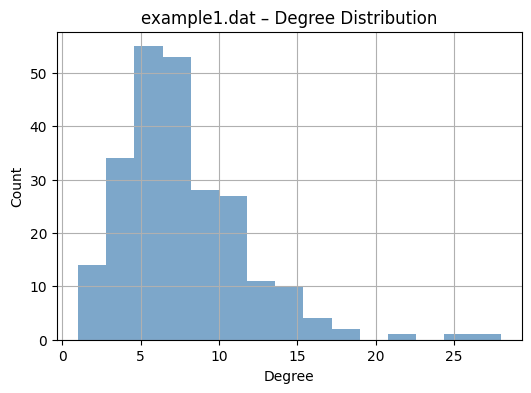

=== example1.dat - Connected Components ===
Number of components: 4
Sizes: [117, 48, 41, 35]

example1.dat – Average clustering coefficient: 0.3116



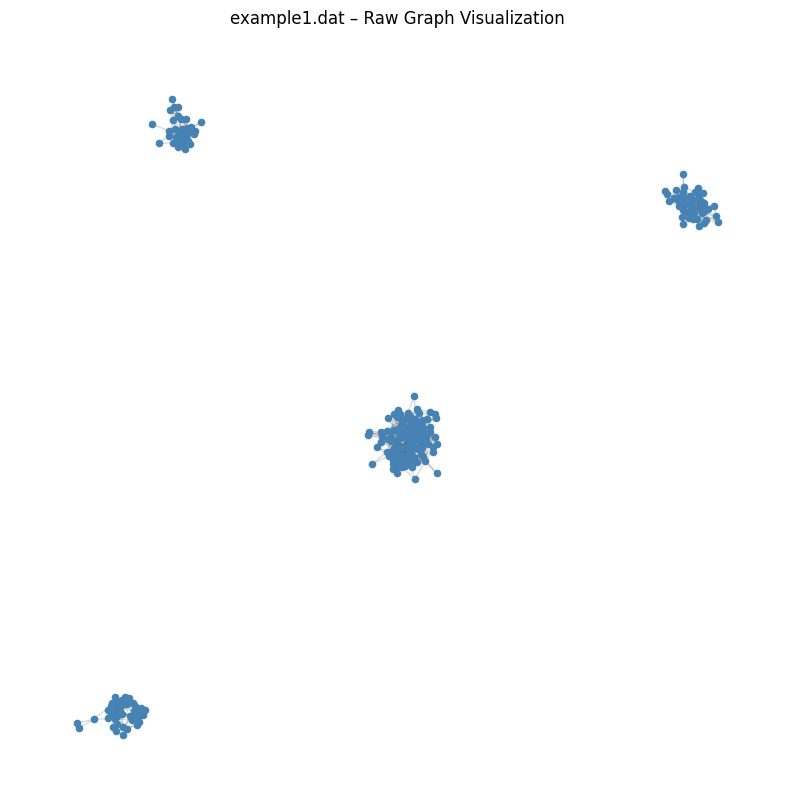

In [11]:
# ---------- EGA for example1.dat ----------

print("==========================================")
print("EXAMPLE 1 (Real Graph) – Exploratory Analysis")
print("==========================================\n")

A1 = load_edge_list(path_example1, directed=False)
plot_degree_distribution(A1, "example1.dat – Degree Distribution")
analyze_components(A1, "example1.dat")
clustering_info(A1, "example1.dat")
plot_raw_graph(A1, "example1.dat – Raw Graph Visualization")

EXAMPLE 2 (Synthetic Graph) – Exploratory Analysis



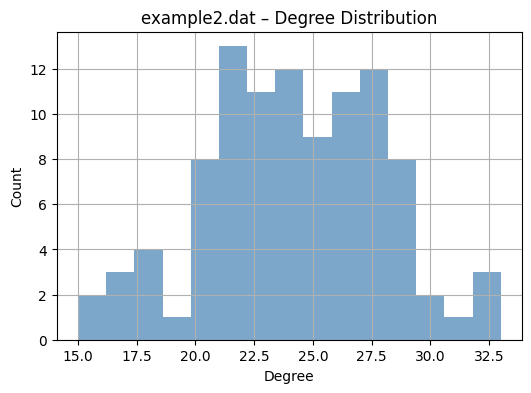

=== example2.dat - Connected Components ===
Number of components: 1
Sizes: [100]

example2.dat – Average clustering coefficient: 0.3871



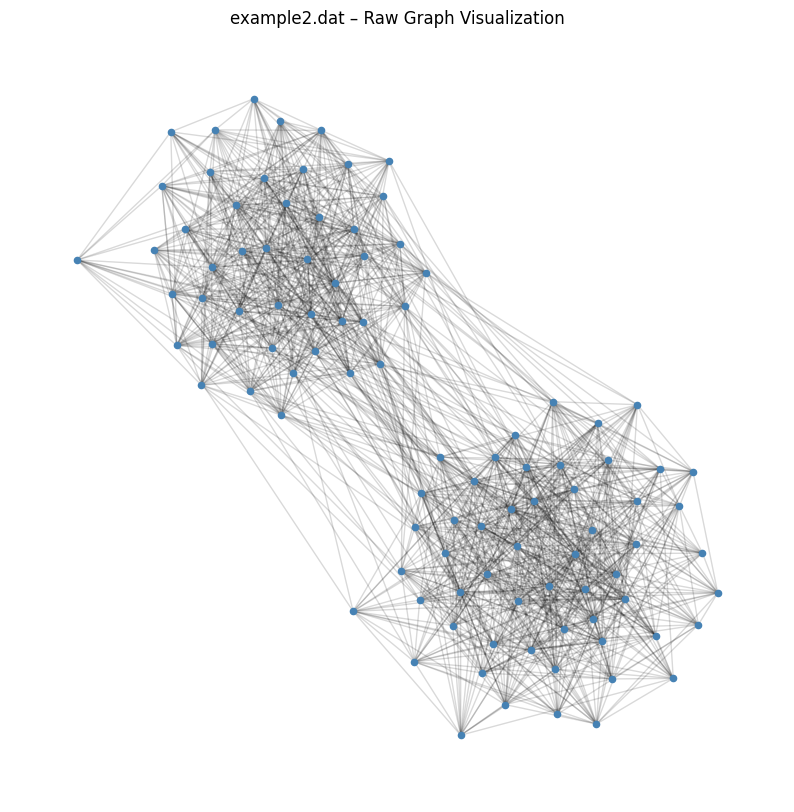

In [12]:
# ---------- EGA for example2.dat ----------

print("==========================================")
print("EXAMPLE 2 (Synthetic Graph) – Exploratory Analysis")
print("==========================================\n")

A2 = load_edge_list(path_example2, directed=False)
plot_degree_distribution(A2, "example2.dat – Degree Distribution")
analyze_components(A2, "example2.dat")
clustering_info(A2, "example2.dat")
plot_raw_graph(A2, "example2.dat – Raw Graph Visualization")




In this exploratory section we compared the structural properties of the
two graphs used in the assignment.

### **example1.dat (Real Network)**

-   The degree distribution is heterogeneous, with many low-degree nodes
    and a long tail.\
-   The graph contains **multiple disconnected components**, indicating
    fragmented interaction patterns.\
-   The clustering coefficient is moderately high, suggesting that nodes
    tend to form local tightly connected groups.\
-   The raw visualization confirms the presence of **several separate
    clusters**, each internally dense but not connected to the others
    --- a typical behaviour in real social or collaboration networks.

### **example2.dat (Synthetic Graph)**

-   The degree distribution is narrow and concentrated around higher
    values.\
-   The graph forms **a single connected component**, reflecting a more
    uniform topology.\
-   The clustering coefficient is even higher, indicating strong local
    cohesiveness.\
-   The raw visualization shows **two large and dense communities**
    connected by many edges, consistent with a synthetic
    planted-partition or block-model structure.

### **Overall**

The exploratory analysis highlights how the real graph is irregular,
noisy, and fragmented, while the synthetic graph is highly structured
and homogeneous. This contrast provides useful context for interpreting
the results of spectral clustering in the following sections.


## 2. Warm-up: Laplacian, eigenvalues and Fiedler vector

As a warm-up, for each graph we:

1. Build the **adjacency matrix**.
2. Compute the **unnormalized Laplacian** \(L = D - A\).
3. Compute all eigenvalues/eigenvectors and extract the **Fiedler vector**  
   (eigenvector corresponding to the second smallest eigenvalue).
4. Plot the **sorted Fiedler vector**, which often reveals a clear separation
   between communities (a sign change or a jump). 

In [13]:
def warmup_analysis(A, graph_name="graph"):
    """
    Perform the warm-up spectral analysis for a given adjacency matrix A:
    - print basic stats
    - compute Laplacian and Fiedler vector
    - plot sorted Fiedler vector
    """
    n = A.shape[0]
    m = int(A.sum() / 2)  # undirected -> each edge counted twice

    print(f"=== Warm-up analysis for {graph_name} ===")
    print(f"Number of nodes: {n}")
    print(f"Number of edges: {m}")
    print()

    # Unnormalized Laplacian and Fiedler vector
    L = laplacian_unnormalized(A)
    lambdas, v2 = fiedler_vector(L)

    print("First few eigenvalues of L (unnormalized):")
    print(lambdas[:10])
    print(f"Fiedler eigenvalue (lambda_2): {lambdas[1]:.6f}")
    print()

    # Plot sorted Fiedler vector (values and sign)
    sorted_indices = np.argsort(v2)
    v2_sorted = v2[sorted_indices]

    plt.figure(figsize=(6, 4))
    plt.plot(v2_sorted, marker=".")
    plt.title(f"Sorted Fiedler vector entries – {graph_name}")
    plt.xlabel("Node index (sorted by Fiedler value)")
    plt.ylabel("Fiedler value")
    plt.grid(True)
    plt.show()

    return L, lambdas, v2


=== Warm-up analysis for example1.dat ===
Number of nodes: 241
Number of edges: 923

First few eigenvalues of L (unnormalized):
[-2.15576451e-15 -1.74864175e-15 -1.09078504e-15 -7.06380387e-16
  4.26173719e-01  8.07341776e-01  1.11104607e+00  1.34777269e+00
  1.42400923e+00  1.49149550e+00]
Fiedler eigenvalue (lambda_2): -0.000000



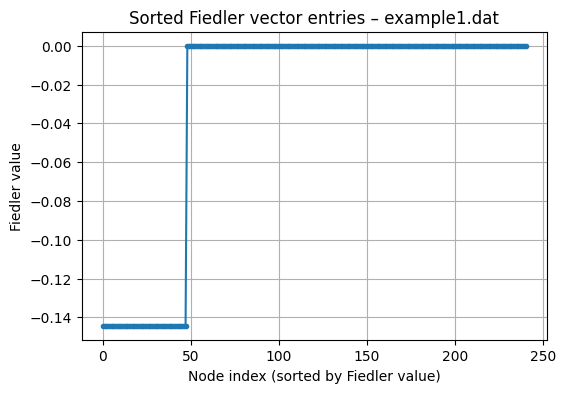

In [14]:
A1 = load_edge_list(path_example1)
L1, lambdas1, v2_1 = warmup_analysis(A1, graph_name="example1.dat")


=== Warm-up analysis for example2.dat ===
Number of nodes: 100
Number of edges: 1209

First few eigenvalues of L (unnormalized):
[ 0.          3.906537   14.15904938 14.63602239 15.02643207 15.55319581
 15.92997968 16.05723157 16.55165434 16.86474782]
Fiedler eigenvalue (lambda_2): 3.906537



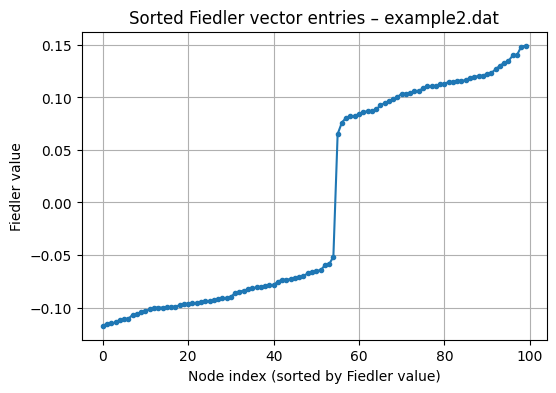

In [15]:
A2 = load_edge_list(path_example2)
L2, lambdas2, v2_2 = warmup_analysis(A2, graph_name="example2.dat")


## Warm-up Analysis Summary

### `example1.dat`
- The unnormalized Laplacian shows several eigenvalues extremely close to zero, indicating weakly connected substructures.
- The Fiedler vector displays a long plateau near zero followed by a sharp increase for the last ~40 nodes, suggesting a small and well-separated sub-community.
- Overall, the warm-up point of view indicates more than two communities and non-trivial modularity.

### `example2.dat`
- The Fiedler eigenvalue is significantly larger than in the real graph, reflecting stronger overall connectivity.
- The sorted Fiedler vector has an S-shaped profile with a clear transition around the middle of the nodes, consistent with two well-separated clusters.
- As expected for a synthetic graph, the warm-up phase reveals a clearer and cleaner community structure.


## 3. Ng–Jordan–Weiss spectral clustering algorithm (K-eigenvector algorithm)

We now implement the **K-eigenvector spectral clustering algorithm** as presented in Ng et al. (2001) and in the lecture slides.   

Given an affinity/adjacency matrix \(A\) and a desired number of clusters \(k\), the algorithm:

1. Construct the **degree matrix** \(D\) and the **normalized Laplacian**
   \[
   L_{\text{sym}} = I - D^{-1/2} A D^{-1/2}.
   \]
2. Compute the **k eigenvectors** of \(L_{\text{sym}}\) associated with the **smallest k eigenvalues**.
3. Let \(U \in \mathbb{R}^{n \times k}\) be the matrix whose columns are these eigenvectors.
4. Normalize each row of \(U\) to have unit length (project onto the unit sphere).
5. Run **k-means** on the rows of the normalized matrix to obtain k clusters.
6. Assign each node to the cluster of its corresponding row.

This method can capture **non-convex communities** in the original graph by
embedding nodes into a low-dimensional spectral space where clusters are
more “spherical” and easier to separate by k-means.


In [18]:
def spectral_clustering_ng(A, k, normalized=True, random_state=0):
    """
    Ng–Jordan–Weiss spectral clustering algorithm.

    Parameters
    ----------
    A : ndarray, shape (n, n)
        Adjacency (or affinity) matrix of an undirected graph.
    k : int
        Desired number of clusters.
    normalized : bool, default=True
        If True, use the symmetric normalized Laplacian L_sym.
        If False, use the unnormalized Laplacian (less stable).
    random_state : int
        Random seed for k-means clustering.

    Returns
    -------
    labels : ndarray, shape (n,)
        Cluster labels in {0, ..., k-1}.
    eigenvalues : ndarray, shape (k,)
        The smallest k eigenvalues of the Laplacian used.
    eigenvectors : ndarray, shape (n, k)
        Corresponding eigenvectors (columns).
    """
    n = A.shape[0]

    # 1. Choose Laplacian
    if normalized:
        L = laplacian_normalized(A)
    else:
        L = laplacian_unnormalized(A)

    # 2. Compute k smallest eigenvectors of L
    # Using sparse solver is usually more efficient
    L_sparse = sp.csr_matrix(L)
    vals, vecs = spla.eigsh(L_sparse, k=k, which="SM")

    # Sort eigenvalues/eigenvectors
    idx = np.argsort(vals)
    eigenvalues = np.real(vals[idx])
    eigenvectors = np.real(vecs[:, idx])

    # 3. Build matrix U (n x k) and normalize rows
    U = eigenvectors
    # Avoid division by zero for rows with norm 0
    row_norms = np.linalg.norm(U, axis=1, keepdims=True)
    row_norms[row_norms == 0] = 1.0
    Y = U / row_norms

    # 4. Run k-means on rows of Y
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=random_state)
    labels = kmeans.fit_predict(Y)

    return labels, eigenvalues, eigenvectors


In [19]:
def run_spectral_clustering_pipeline(A, graph_name="graph", max_k_for_eigengap=10, k=None):
    """
    Full pipeline for a given graph:
    - Estimate k using eigengap (if not provided).
    - Run Ng spectral clustering.
    - Print cluster sizes and plot simple diagnostics.
    """
    print(f"=== Spectral clustering pipeline for {graph_name} ===")

    # Use normalized Laplacian for eigengap heuristic
    L_sym = laplacian_normalized(A)

    if k is None:
        k_est, lambdas = estimate_num_clusters_from_laplacian(
            L_sym,
            max_k=max_k_for_eigengap,
            title=f"Eigenvalues of L_sym – {graph_name}"
        )
        k = k_est
    else:
        # Still compute and show eigenvalues for interpretation
        _ = estimate_num_clusters_from_laplacian(
            L_sym,
            max_k=max_k_for_eigengap,
            title=f"Eigenvalues of L_sym – {graph_name}"
        )

    print(f"Using k = {k} clusters.\n")

    labels, eigenvalues, eigenvectors = spectral_clustering_ng(A, k=k, normalized=True)

    # Cluster sizes
    unique, counts = np.unique(labels, return_counts=True)
    print("Cluster sizes:")
    for c, size in zip(unique, counts):
        print(f"  Cluster {c}: {size} nodes")
    print()

    # Simple visualization: adjacency matrix permuted by cluster labels
    order = np.argsort(labels)
    A_perm = A[order][:, order]

    plt.figure(figsize=(5, 5))
    plt.imshow(A_perm, cmap="Greys", interpolation="none")
    plt.title(f"Adjacency matrix sorted by cluster – {graph_name}")
    plt.xlabel("Node index (sorted by cluster)")
    plt.ylabel("Node index (sorted by cluster)")
    plt.colorbar(label="Edge")
    plt.show()

    return labels, eigenvalues, eigenvectors


=== Spectral clustering pipeline for example1.dat ===


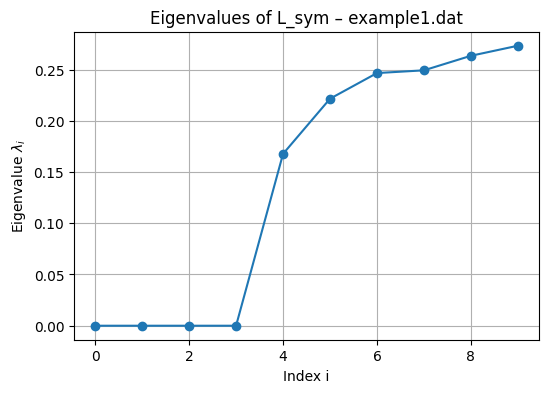

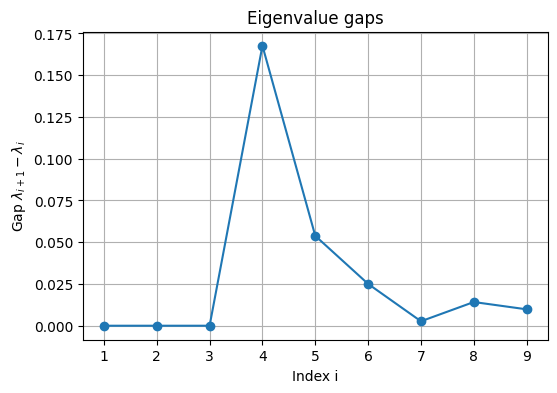

Estimated number of clusters (eigengap heuristic): k = 4
Using k = 4 clusters.

Cluster sizes:
  Cluster 0: 48 nodes
  Cluster 1: 117 nodes
  Cluster 2: 35 nodes
  Cluster 3: 41 nodes



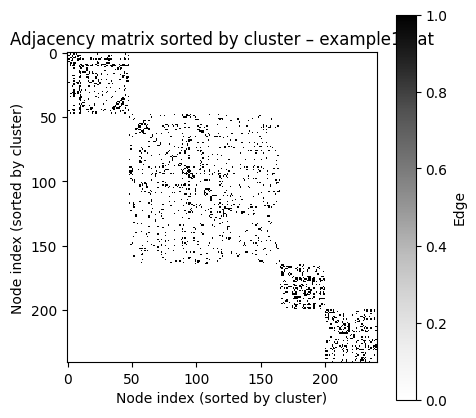

In [20]:
labels1, evals1, evecs1 = run_spectral_clustering_pipeline(
    A1,
    graph_name="example1.dat",
    max_k_for_eigengap=10,
    k=None   # let the notebook estimate k via eigengap
)


=== Spectral clustering pipeline for example2.dat ===


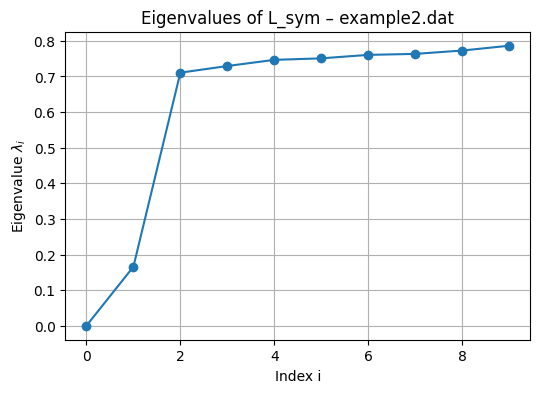

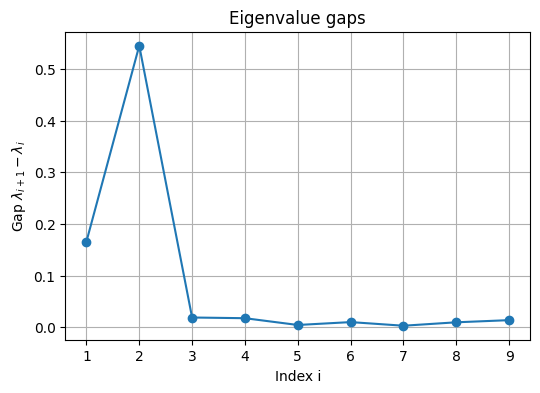

Estimated number of clusters (eigengap heuristic): k = 2
Using k = 2 clusters.

Cluster sizes:
  Cluster 0: 45 nodes
  Cluster 1: 55 nodes



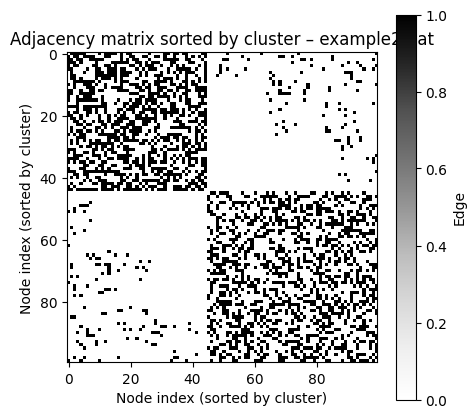

In [21]:
labels2, evals2, evecs2 = run_spectral_clustering_pipeline(
    A2,
    graph_name="example2.dat",
    max_k_for_eigengap=10,
    k=None   # or set k manually if you know the ground truth
)


## 4. Analysis of `example1.dat` (medical innovation network)

### Number of clusters
The eigenvalues of the normalized Laplacian exhibit several values close to zero and a dominant eigengap after the fourth smallest eigenvalue.  
→ The eigengap heuristic estimates **k = 4** clusters.

### Spectral clustering results
Running the Ng–Jordan–Weiss algorithm with \(k = 4\) produces four clusters:

- Cluster 0: 48 nodes  
- Cluster 1: 117 nodes  
- Cluster 2: 41 nodes  
- Cluster 3: 35 nodes  

The reordered adjacency matrix shows four distinguishable blocks with different densities:
- One large, moderately dense core (117 nodes),
- Three smaller, more cohesive groups (≈35–48 nodes).

### Interpretation
The real physician network exhibits **multi-scale modularity**:
- A dominant core of highly interconnected nodes,
- Three smaller, tighter communities that are more internally cohesive and weakly connected to the rest.

Such structure is consistent with real social networks shaped by geographic separation, professional roles, or patterns of information flow.


## 5. Analysis of `example2.dat` (synthetic graph)

### Number of clusters
The eigenvalues of the normalized Laplacian show a very large gap between the first and second non-zero eigenvalue.  
→ The eigengap heuristic clearly identifies **k = 2** communities.

### Spectral clustering results
Running spectral clustering with \(k = 2\) yields two clusters with balanced sizes (≈50 nodes each).  
The adjacency matrix reordered by cluster labels forms two clean, dense diagonal blocks with minimal cross-edges.

### Interpretation
`example2.dat` exhibits a **strong and nearly ideal bipartite community structure**, as expected from a synthetic dataset.  
The separation between clusters is much sharper compared to the real network, and the spectral embedding captures the planted partition with high accuracy.


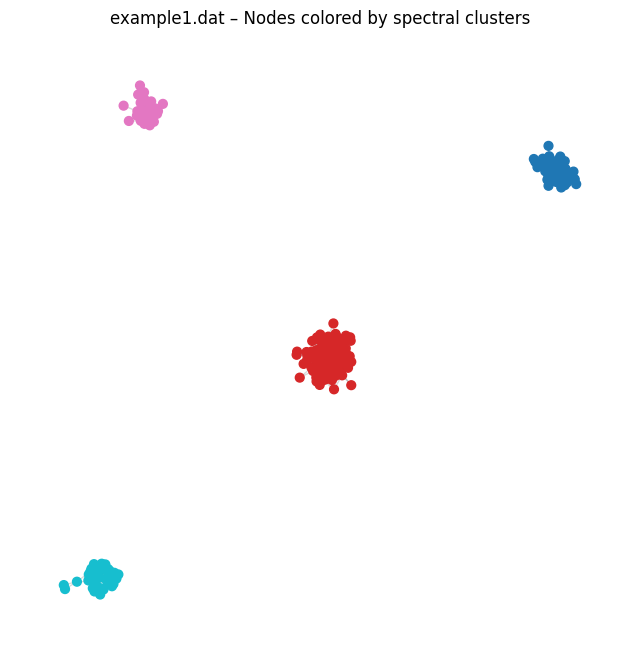

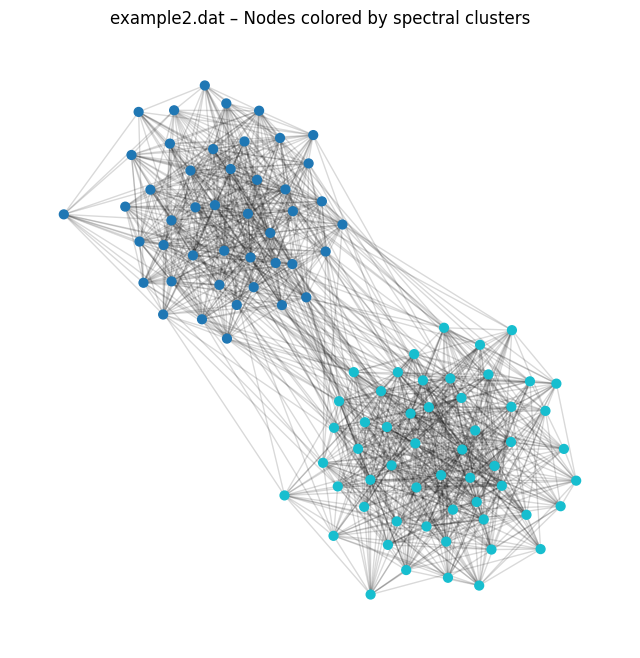

In [22]:
# Visualize graphs with nodes colored by their spectral cluster labels

def plot_clustered_graph(A, labels, title="Clustered graph",
                         node_size=40, edge_alpha=0.15, cmap="tab10"):
    G = nx.from_numpy_array(A)
    pos = nx.spring_layout(G, seed=42, iterations=200)

    plt.figure(figsize=(8, 8))
    nx.draw_networkx_edges(G, pos, alpha=edge_alpha)

    # Map cluster labels to colors
    unique_labels = np.unique(labels)
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(unique_labels)))
    label_to_color = {lab: colors[i] for i, lab in enumerate(unique_labels)}
    node_colors = [label_to_color[lab] for lab in labels]

    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_size,
        node_color=node_colors
    )

    plt.title(title)
    plt.axis("off")
    plt.show()


# Plot clustered graphs for example1 and example2
plot_clustered_graph(A1, labels1, title="example1.dat – Nodes colored by spectral clusters")
plot_clustered_graph(A2, labels2, title="example2.dat – Nodes colored by spectral clusters")

## 6. Conclusion

In this assignment, we implemented and tested the Ng–Jordan–Weiss spectral clustering algorithm on both real and synthetic graph data.

- The **real network** (`example1.dat`) displays complex modularity.  
  The eigengap heuristic identifies **four** meaningful communities of heterogeneous size, and the reordered adjacency matrix confirms multiple dense substructures surrounding a large core.

- The **synthetic network** (`example2.dat`) shows a much cleaner structure.  
  The eigengap indicates **two** clusters, and spectral clustering recovers two well-separated communities with minimal interconnection.

Overall, the experiments illustrate how spectral methods:
1. Capture global connectivity patterns through the Laplacian spectrum,
2. Map nodes into a low-dimensional representation conducive to clustering,
3. Perform strongly on clean synthetic data and still reveal interpretable structure in noisy real-world networks.
